In [1]:
!pip3 install openai python-dotenv opencv-python requests

In [2]:
# import required packages

from openai import OpenAI
from dotenv import load_dotenv
from pprint import pprint
from IPython.display import display, Image, Audio

import json
import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time

import os
import getpass
import requests


# load env file
load_dotenv()

# Load OpenAI API client
client = OpenAI()


# Extract frames from a video


In [3]:
video = cv2.VideoCapture("sample.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")
print(base64Frames[0])


181 frames read.
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyNrXw2LOc6To83m/89ua2vhja6BrF4NK8QaRCOnlSzc+tdibW2UZ2VzOr3d/YaxF5Zw4bNsR/ezX7fV2P55ex3V18MfCd0oWTTABjsNtY/iT4W+EvDujTXul6eFm8r9zhuM101nfXV1awYfnyv3uKp6r

## Display a sample frame

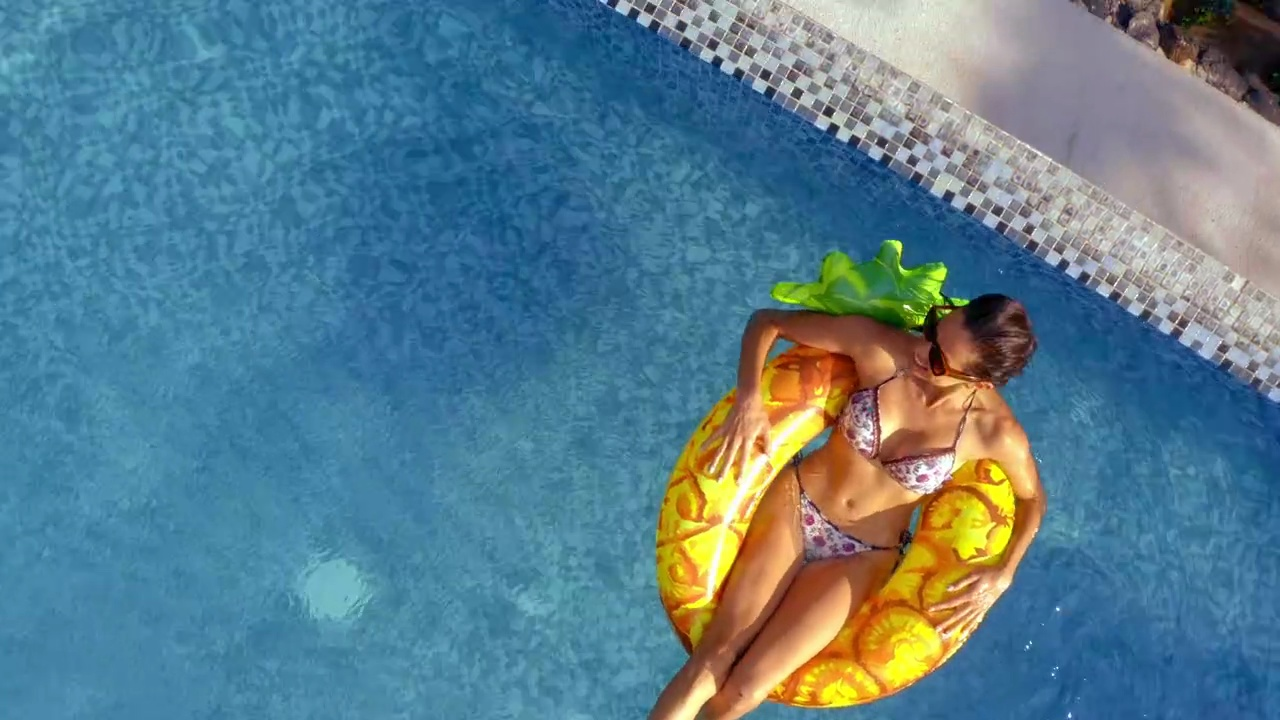

In [4]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    # time.sleep(0.025)

In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            """These are frames from a video that I want to upload. Take a step by step process and analyze the design composition of the video. 
            Think about how the design elements are placed, the relationship between them, and the overall aesthetic of the video. 
            Please provide color analysis, overall mood or tone of the video, and any other relevant insights.""",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 1000,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Analyzing the design composition of the video frames, we can break down the various elements as follows:

### Color Analysis
- **Primary Colors:**
  * **Blue:** Dominates the composition as the water background. Various hues of blue are present, ranging from deep, almost navy blue to lighter, sky-like blues. This creates a serene and refreshing feel.
  * **Yellow/Orange:** The inflatable floatation device (which appears to be a pineapple) is a bright yellow with orange accents, standing out vividly against the blue water. This high contrast draws the viewer's attention immediately to the central subject.
  * **Green:** There are bright green leaves on the flotation device, adding a vibrant touch that complements the primary colors.

### Overall Mood or Tone
- **Relaxation and Calmness:** The combination of blue water, the relaxing posture of the subject, and the overall sunny setting contribute to a feeling of tranquility and leisure. The floating position suggests relaxation, vacation

## Generate audio description

In [6]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "sky"
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)